# Clustering (Agrupamiento) usando K-means

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oramosul/abd-files/blob/main/spark/3-spark-mllib/5-Clustering-kmeans.ipynb)

La implementación de MLlib incluye una versión paralelizada del método <a href="http://en.wikipedia.org/wiki/K-means%2B%2B">k-means++</a>, llamada <a href="http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf">kmeans||</a>.

Los datos de este ejemplo están adaptados del repositorio UCI: https://archive.ics.uci.edu/ml/datasets/seeds.

Los datos contienen datos de granos de trigo correspondientes a tres variedades diferentes. Cada variedad tiene 70 elementos seleccionados aleatoriamente. Se utilizó rayos X para realizar la visualización de la estructura interna del grano.

In [ ]:
# Solo necesario si se usa Google Colab
!pip install -q pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder.getOrCreate()

In [3]:
# Carga de archivos
!wget -q https://raw.githubusercontent.com/oramosul/abd-files/main/spark/datos/datos_semillas.csv

In [10]:
# Cargar los datos
dfsemillas = spark.read.csv("datos_semillas.csv", header=True, inferSchema=True)

#dfsemillas.printSchema()
dfsemillas.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.175|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
only showing top 5 rows



In [11]:
# Resumen de los datos
dfsemillas.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

## 1.&nbsp;Pre-procesamiento de datos

In [6]:
from pyspark.ml.feature import VectorAssembler

In [19]:
# Preparar los datos en una columna llamada "atributos"
vec_assembler = VectorAssembler(inputCols=dfsemillas.columns,
                                outputCol='atributos')

# Transformar los datos
df0 = vec_assembler.transform(dfsemillas)

# Mostrar el DF: se añade una columna al final con los "atributos" en formato adecuado para Spark
df0.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|           atributos|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|[15.26,14.84,0.87...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|[14.88,14.57,0.88...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|[14.29,14.09,0.90...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|[13.84,13.94,0.89...|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.17

Al realizar agrupamiento solo se tiene los atributos (sin etiquetas), por lo que aquí se quitará el resto y solo se utilizará la columna de atributos llamada, en este caso, `atributos`

In [20]:
df1 = df0.select('atributos')
df1.show(5, truncate=False)

+---------------------------------------------------------+
|atributos                                                |
+---------------------------------------------------------+
|[15.26,14.84,0.871,5.763,3.312,2.221,5.22]               |
|[14.88,14.57,0.8811,5.553999999999999,3.333,1.018,4.956] |
|[14.29,14.09,0.905,5.291,3.3369999999999997,2.699,4.825] |
|[13.84,13.94,0.8955,5.324,3.3789999999999996,2.259,4.805]|
|[16.14,14.99,0.9034,5.6579999999999995,3.562,1.355,5.175]|
+---------------------------------------------------------+
only showing top 5 rows



Debido a que se utilizará k-means, y este método se basa en distancias, se realizará el escalamiento de los datos

In [33]:
from pyspark.ml.feature import StandardScaler

In [23]:
# El valor de salida es z = (x-media)/(deviacion_estandar)
scaler = StandardScaler(inputCol="atributos", outputCol="atributos_escalados",
                        withStd=True, withMean=True)

# Transformar los datos (estandarizar o normalizar)
df = scaler.fit(df1).transform(df1)
df.show(5, truncate=False)

+---------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|atributos                                                |atributos_escalados                                                                                                                            |
+---------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|[15.26,14.84,0.871,5.763,3.312,2.221,5.22]               |[0.1417590374201429,0.21494881882893777,6.0457329695830086E-5,0.30349300591570155,0.1413640352262526,-0.983799125450589,-0.38266305360010433]  |
|[14.88,14.57,0.8811,5.553999999999999,3.333,1.018,4.956] |[0.011161355751617185,0.008204153390413858,0.42749377817201406,-0.16822269737916232,0.19696159121909768,-1.783900766822316,-0

### Entrenamiento

In [34]:
# Creación del modelo: usando 3 clústeres
kmeans = KMeans(featuresCol='atributos_escalados',
                predictionCol='prediccion',
                k=3)

# Entrenar el modelo
modelo = kmeans.fit(df)

In [35]:
# Evaluar a través del SSE dentro de la clase
sse = modelo.summary.trainingCost
print("Suma de errores cuadráticos dentro de la clase: {:.3f}".format(sse))

Suma de errores cuadráticos dentro de la clase: 429.029


In [36]:
# Centros de los clústeres
centros = modelo.clusterCenters()

print("Centros de los clústeres: ")
for centro in centros:
    print(centro)

Centros de los clústeres: 
[-0.21947452 -0.25483135  0.41691375 -0.35241325 -0.06277989 -0.65225244
 -0.67516043]
[ 1.21393655  1.22274702  0.53414051  1.20787809  1.1209022  -0.06246133
  1.26254101]
[-1.04143096 -1.0111329  -1.0339614  -0.88595281 -1.1184461   0.7975602
 -0.58206059]


Luego se intentará ver el error con diferentes valores de K. En este caso no es necesario ya que a priori se sabe que hay solamente 3 grupos, pero se incluye aquí solo para ilustrar cómo se podría realizar.

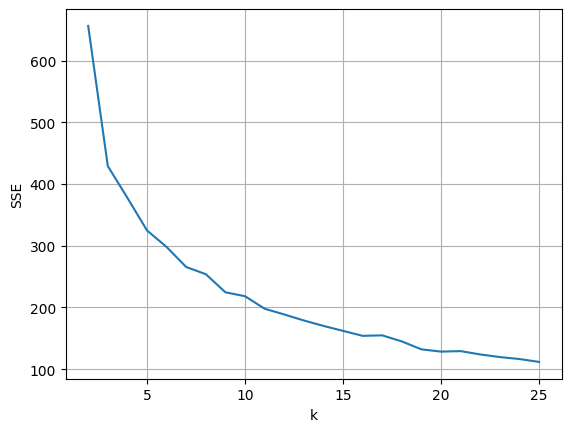

In [28]:
# Escoger el número de clústeres
import numpy as np
import matplotlib.pyplot as plt

Ks = np.arange(2, 26)
SSEs = np.zeros(Ks.shape)

for i, k in enumerate(Ks):
    kmeans2 = KMeans(featuresCol='atributos_escalados', k=k)
    modelo2 = kmeans2.fit(df)
    sse = modelo2.summary.trainingCost
    SSEs[i] = sse

plt.plot(Ks, SSEs)
plt.xlabel('k'); plt.ylabel('SSE')
plt.grid()
plt.show()

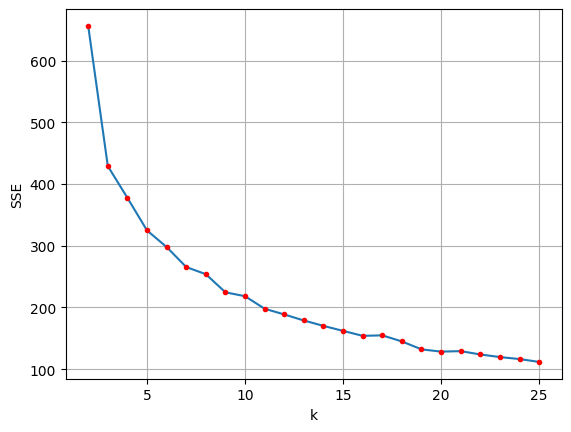

In [29]:
plt.plot(Ks, SSEs)
plt.plot(Ks, SSEs, 'r.')
plt.xlabel('k'); plt.ylabel('SSE')
plt.grid()
plt.show()

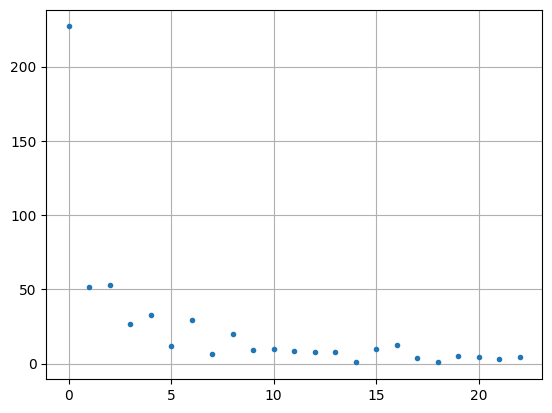

In [30]:
n1 = len(SSEs)-1
dif = np.zeros(n1)
for i in range(n1):
  dif[i] = np.abs(SSEs[i+1] - SSEs[i])
plt.plot(dif,'.')
plt.grid()

### Predicción

In [38]:
# Predicción de las clases
prediccion = modelo.transform(df)

# Esquema (se agrega "prediction" al final del data frame)
prediccion.printSchema()

root
 |-- atributos: vector (nullable = true)
 |-- atributos_escalados: vector (nullable = true)
 |-- prediccion: integer (nullable = false)



In [40]:
# Seleccionar solamente los atributos y las predicciones
prediccion.select(['atributos_escalados', 'prediccion']).show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------+----------+
|atributos_escalados                                                                                                                            |prediccion|
+-----------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[0.1417590374201429,0.21494881882893777,6.0457329695830086E-5,0.30349300591570155,0.1413640352262526,-0.983799125450589,-0.38266305360010433]  |0         |
|[0.011161355751617185,0.008204153390413858,0.42749377817201406,-0.16822269737916232,0.19696159121909768,-1.783900766822316,-0.9198155967470747]|0         |
|[-0.1916087289442528,-0.35934191850029623,1.4389449037295805,-0.7618170991329825,0.20755160188440017,-0.6658867525697202,-1.1863571995965194]  |0         |
|[-0.34626387828855976,-0.4742000659661433,1.0369036613531